## Prepare the data

### 1. Load the fine-tuning data

In [1]:
import json

file_path = "../output/fine_tuning/data/fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

### 2. Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [ ]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="../output/tokenizer/darija_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. Tokenize the sequences

In [4]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

120

### 4. Split the data

We need to be careful when splitting the data. We want to keep the multi-turn conversations complete in each part. So, the training and validation sets should start with a `You` message and end with an `Assistant` message.

In [5]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>La Wikipedia Del Porno(Andres)'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>La Wikipedia Del Porno(Andres)
End message: <|startoftext|>La Wikipedia Del Porno(Andres)

Validation set: 
Start message: <|startoftext|>Pedro Guill Ferri
End message: <|startoftext|>La Wikipedia Del Porno(Andres)


We got the index that we should use to split the data. Now, let's split the tokenized data.

In [6]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

Now, we need to combine the `You` and `Assistant` turns into one sequence. We will make sure that the resulting sequence does not exceed the `block_size`.

In [7]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [8]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 10405
Length after: 5202

Validation data
Length before: 548
Length after: 274


Let's convert each sequence of tokens into a tensor.

In [9]:
import torch

train_data = torch.tensor(combined_train_data)
val_data = torch.tensor(combined_val_data)

ValueError: expected sequence of length 137 at dim 1 (got 78)

Since our token sequences don't all have the same length, we can't turn the data into a tensor all at once. To do that, all sequences need to have the same length.

That's why we need to use padding to fix this problem. We can add padding at the start or end of the sequence. Let's add it to the start.

In [10]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([5202, 256]), torch.Size([274, 256]))

In [11]:
train_data_tensor[0]

tensor([1024,   76,   97,   32,   87,  105,  690,  369,  298,   97,   32,   68,
         538,   32,  635,  588,   40,  866,  570,  265,   41, 1025,   87,  101,
          63,   10,   84,  101,   32,  406,  381,  115,  426,   63,   10,   65,
         121,  101,   10,   79,  121,  101,   42,   10,  691,   98,  307,   32,
          98,  108,  293,  107,   32,  288,  416,   10,   67,  391,  111,   32,
         524,   32,  558,   32,  109,  305,  307,   32,  334,   32,  299,  547,
          32,   99,  381,  111,   32,  292,   32,  334,  801,  105,  111,   32,
         524,   32,  356,  321,   32,  100,  505,  111,   32,  334,  108,   32,
         103,  381,  943,  105,  111,   32,  334,   32,  299,  547,   10,   72,
         299,   32,  422,  308,  561,   32,  265,  111,   32,  588,   63, 1026,
        1024,   80,  101,  100,  458,   32,   71,  117,  105,  361,   32,   70,
         261,  381, 1025,  673, 1026, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 10

In [12]:
val_data_tensor[0]

tensor([1024,   80,  101,  100,  458,   32,   71,  117,  105,  361,   32,   70,
         261,  381, 1025,  390,  524,   32,  538,   32,  494,  361,  111,   32,
          97,   32,  350,  369,  122,  305,  111,   32,   97,   32,  380,  261,
          32,  106,  940,  111,  112,  397,  265, 1026, 1024,   76,   97,   32,
          87,  105,  690,  369,  298,   97,   32,   68,  538,   32,  635,  588,
          40,  866,  570,  265,   41, 1025,  673, 1026, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 10

### 5. Creat the data loaders

In [13]:
train_data_tensor.shape

torch.Size([5202, 256])

In [15]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [16]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([64, 256]), torch.Size([64, 256]))

## Fine-tuning

### 1. Load the saved checkpoint

In [18]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 512
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

13.795338 M parameters


In [ ]:
checkpoint_path = "../output/pre_training/base_model_checkpoint.pth"
checkpoint = torch.load(checkpoint_path, weights_only=True)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

Generate from the model to make sure that the weights were loaded correctly.

In [20]:
input_tokens = tokenizer.encode("Salam labas ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Salam labas am :v Pepe What Pues no lo has todos Solo q te salir estas en clase Del de movil Jajajajaja xD Dale Toy no salio no busca jajajajaja Toma paja coño acabo de gradugar solo vida la mañana Que voy por el dios mio doble Su puta madre me faltan pokita esa madre xD Bro de tarde por ella foto de las 160 minutos no? Stista 


### 2. Estimate loss

In [21]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

### 3. Save checkpoints

In [22]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [24]:
max_iters = 20
eval_interval = 20
learning_rate = 6e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"../output/fine_tuning/run_3/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 1.9227, val loss 2.4710
iteration 0 / step 20: train loss 1.8439, val loss 2.4213
iteration 0 / step 40: train loss 1.7785, val loss 2.3789
iteration 0 / step 60: train loss 1.7373, val loss 2.3740
iteration 0 / step 80: train loss 1.7091, val loss 2.3639
iteration 0 / step 81: train loss 1.7066, val loss 2.3603
iteration 1 / step 0: train loss 1.7084, val loss 2.3551
iteration 1 / step 20: train loss 1.6843, val loss 2.3616
iteration 1 / step 40: train loss 1.6601, val loss 2.3685
iteration 1 / step 60: train loss 1.6418, val loss 2.3702
iteration 1 / step 80: train loss 1.6237, val loss 2.3468
iteration 1 / step 81: train loss 1.6235, val loss 2.3520
iteration 2 / step 0: train loss 1.6249, val loss 2.3551
iteration 2 / step 20: train loss 1.6084, val loss 2.3557
iteration 2 / step 40: train loss 1.5904, val loss 2.3457
iteration 2 / step 60: train loss 1.5768, val loss 2.3226
iteration 2 / step 80: train loss 1.5659, val loss 2.3376
iteration 2 / ste

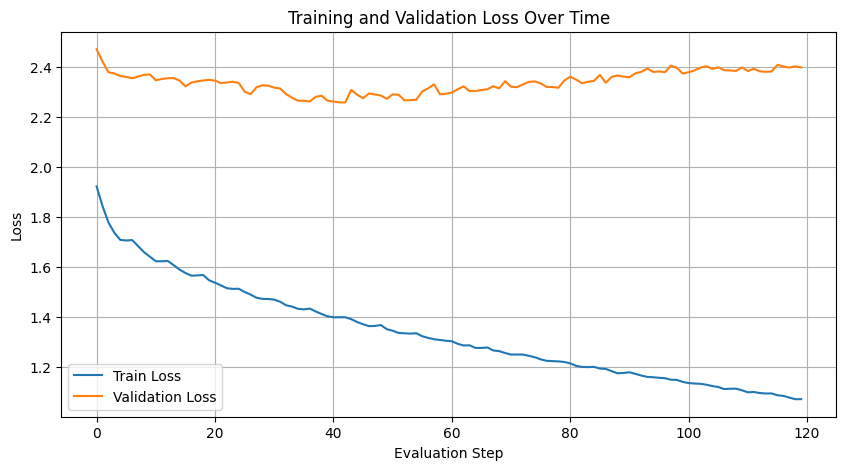

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [43]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "Hola bro."
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: Hola bro.
Assistant: creo mundo a que no me las faltante muertos
xD
Eso cerraro
